In [1]:
import os
import csv
from PIL import Image
import numpy as np
import numpy.linalg as la
from scipy import linalg
from scipy import spatial
from scipy import signal
import matplotlib.pyplot as plt
from math import *
import time

%matplotlib inline

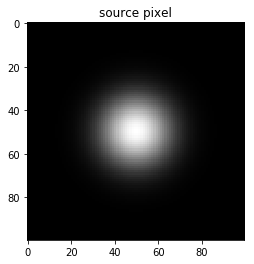

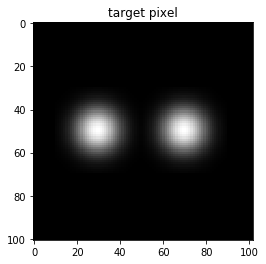

In [9]:
###x: Generate an image of 2D Gaussian kernel, with image size of 100x100 pixels###
###y: Generate an image of 2D annulus, with image size of 100x100 pixels###
def rho_T(x,T,rho_x,delta = 5e3):
    T0 = T[:,0]
    T1 = T[:,1]
    x0T0 = x[0]-T[:,0]
    x1T1 = x[1]-T[:,1]
    argexp = -delta*(x0T0**2+x1T1**2)
    exp_v = np.exp(argexp)
    return exp_v.dot(rho_x)
def gkern(kernlen, std):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d
def annulus(L,W):
    r = np.random.normal(0.9,0.1,100000)
    theta = 2*pi*np.random.uniform(0,1,100000)
    y_0 = np.zeros((100000,2))
    y_0[:,0]=0.3*r*np.cos(theta)+0.5
    y_0[:,1]=0.3*r*np.sin(theta)+0.5
    x_0 = np.zeros((L*W,2))
    for i in range(L*W):
        x_0[i][0] = (i//W)/L
        x_0[i][1] = (i%W)/W

    w = np.array(100000*[1e-5])
    pixels = np.array([rho_T(x_0[i], y_0[:,:2],w,delta = 1e3) for i in range(len(x_0))])
    n_pixels = np.array([1.0/pixels.sum()*pixels])
    x = np.concatenate((x_0,n_pixels.T), axis=1)
    
    return x, pixels
def Gaussian_mixture(L1,W1,sizeG,std,nml):
    x_0 = np.zeros((L1*W1,2))
    for i in range(L1*W1):
        x_0[i][0] = (i//W1)/L1
        x_0[i][1] = (i%W1)/W1


    Gaussian = gkern(sizeG,std)
    
    rec_x = np.zeros((L1,W1))
    rec_x[30:sizeG+30,50:sizeG+50] = Gaussian
    rec_x[30:sizeG+30,10:sizeG+10] = Gaussian
    
    pixels = rec_x.flatten()+1e-23
    n_pixels = np.array([1.0/pixels.sum()*pixels])

    x = np.concatenate(((L1/nml)*x_0,n_pixels.T),axis=1)
    
    return x,pixels
       
def Gaussian_pixels(L1,W1,sizeG,std,nml):
    x_0 = np.zeros((L1*W1,2))
    for i in range(L1*W1):
        x_0[i][0] = (i//W1)/L1
        x_0[i][1] = (i%W1)/W1

    # y_0 = x_0

    Gaussian_1 = gkern(sizeG,std)
    
    rec_x = np.zeros((L1,W1))
    rec_x[10:sizeG+10,10:sizeG+10] = Gaussian_1

    pixels_1 = rec_x.flatten()+1e-23
    n_pixels_1 = np.array([1.0/pixels_1.sum()*pixels_1])

    x = np.concatenate(((L1/nml)*x_0,n_pixels_1.T),axis=1)
    
    return x,pixels_1
x,pixels_1 = Gaussian_pixels(100,100,80,11,100)
y,pixels_2 = Gaussian_mixture(101,102,40,7,100)
image_count = 0
faceX = np.reshape(pixels_1,(100,100))
image_count+=1
plt.figure(image_count)
plt.title('source pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

faceX = np.reshape(pixels_2,(101,102))
image_count+=1
plt.figure(image_count)
plt.title('target pixel')
plt.imshow(faceX,cmap=plt.cm.gray)
# plt.show('hold')

In [10]:
def cutoff(x):
    ###drop pixels with intensity below a certain level; this case we drop pixels with intensity value 0
    nx = []
    for i in range(len(x)):
        if x[i][2] != 0:
            nx.append(x[i])
    return np.array(nx)

def Tx(x,y):
    ###Explicit optimal transport map from a Gaussian distribution (mx,vx) to another Gaussian distribution (my,vy)
    x_0 = x[:,:2]
    y_0 = y[:,:2]
    mx = np.average(x_0,axis=0,weights = x[:,2])
    my = np.average(y_0,axis=0,weights = y[:,2])
    vx = np.cov(x_0.T,aweights = x[:,2])
    vy = np.cov(y_0.T,aweights = y[:,2])
    
    
    sqrt = linalg.sqrtm(vx)
    ml = np.matmul(sqrt,vy)
    m = np.matmul(ml,sqrt)
    sqrt_inv = la.inv(sqrt)
    l = np.matmul(sqrt_inv,linalg.sqrtm(m))
    A = np.matmul(l,sqrt_inv)
    
    x_T = np.zeros((len(x),2))
    x_T = my+np.einsum('ij,jk->ik',A,(x_0-mx).T).T
    
    return x_T
    
def Ty(y,x):
    ###Explicit optimal transport map from a Gaussian distribution (my,vy) to another Gaussian distribution (mx,vx)
    x_0 = x[:,:2]
    y_0 = y[:,:2]
    mx = np.average(x_0,axis=0,weights = x[:,2])
    my = np.average(y_0,axis=0,weights = y[:,2])
    vx = np.cov(x_0.T,aweights = x[:,2])
    vy = np.cov(y_0.T,aweights = y[:,2])
    
    sqrt = linalg.sqrtm(vy)
    ml = np.matmul(sqrt,vx)
    m = np.matmul(ml,sqrt)
    sqrt_inv = la.inv(sqrt)
    l = np.matmul(sqrt_inv,linalg.sqrtm(m))
    A = np.matmul(l,sqrt_inv)
    
    y_T = np.zeros((len(y),2))
    y_T = mx+np.einsum('ij,jk->ik',A,(y_0-my).T).T
    
    return y_T

def compose(x,y,p):
    twx = x.sum(axis=0)[2]
    twy = y.sum(axis=0)[2]
    
    x[:,2] = p/twx*x[:,2]
    y[:,2] = (1-p)/twy*y[:,2]
    
    return np.concatenate([x,y])

####two ways to initialize intermediate sets of points, interpolate_1 picks points using weights of each points
####interpolate_2 picks points with uniform probability
####interpolate_2 works better in practice
def interpolate_1(x,y,K):
    Nx = len(x)
    Ny = len(y)
    d1 = np.arange(Nx)
    d2 = np.arange(Ny)
    wx = x[:,2]
    wy = y[:,2]
    
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    
    z0k = np.zeros((Nx,3))
    zKk = np.zeros((Ny,3))
    z0k[:,2] = x[:,2]
    zKk[:,2] = y[:,2]
    rx = np.random.choice(d1, Nx,replace=False, p=wx)
    ry = np.random.choice(d2, Ny,replace=False, p=wy)
    for k in range(1,K):
        z0k[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        zx = z0k[rx]
        rx_sum=0
        for i in range(Nx):
            if rx_sum >= 1-k/K:
                break
            rx_sum += zx[i][2]
        

        zKk[:,:2] = (1-k/K)*y_T[:,:2]+(k/K)*y[:,:2]
        zy = zKk[ry]
        ry_sum=0
        for j in range(Ny):
            if ry_sum >= k/K:
                break
            ry_sum += zy[j,2]
        z = compose(zx[:i],zy[:j],1-k/K)
        mu.append(z)
    mu.append(y)
    
    return mu,x_K,y_T 

def interpolate_2(x,y,K):
    Nx = len(x)
    Ny = len(y)
    wx = x[:,2]
    wy = y[:,2]
    
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    
    z0k = np.zeros((Nx,3))
    zKk = np.zeros((Ny,3))
    z0k[:,2] = x[:,2]
    zKk[:,2] = y[:,2]
    
    rx = np.random.choice(np.arange(Nx),Nx,replace=False)
    ry = np.random.choice(np.arange(Ny),Ny,replace=False)
    
    for k in range(1,K):
        z0k[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        zx = z0k[rx]
        
        

        zKk[:,:2] = (1-k/K)*y_T[:,:2]+(k/K)*y[:,:2]
        zy = zKk[ry]
        z = compose(zx[:int(Nx*(1-k/K))],zy[:int(Ny*k/K)],1-k/K)
        mu.append(z)
    mu.append(y)
    
    return mu, x_K,y_T

def interpolate_linear(x,y,K):
    Nx = len(x)
    Ny = len(y)
    x_T = Tx(x,y)
    x_K = x_T
    y_T = Ty(y,x)
    mu = []
    mu.append(x)
    for k in range(1,K):
        l = np.zeros((Nx,3))
        l[:,:2] = (1-k/K)*x[:,:2]+(k/K)*x_T[:,:2]
        l[:,2] = x[:,2]
        
        mu.append(l)
    mu.append(y)
    
    return mu,x_K,y_T

In [11]:
# ###test interpolate_1
# x_c = cutoff(x)
# y_c = cutoff(y)
# mu_n, x_K, y_0 = interpolate_1(x_c,y_c,80)

# for k in range(len(mu_n)):
#     if k%5 == 0:
#         pixels_mu = np.array([rho_T(x[i,:2],mu_n[k][:,:2],mu_n[k][:,2]) for i in range(100**2)])
#         imgT = np.reshape(pixels_mu,(100,100))
#         plt.figure(k)
#         plt.title('pic')
#         plt.imshow(imgT,cmap=plt.cm.gray)
#         plt.show('hold')
# #         plt.scatter(mu_n[k][:,0],mu_n[k][:,1], color='red',marker = 'x');
# #         plt.show('hold')

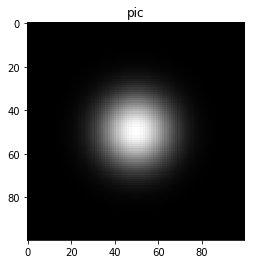

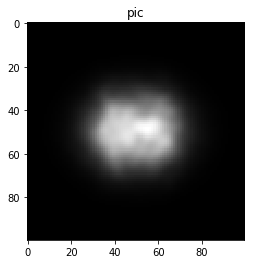

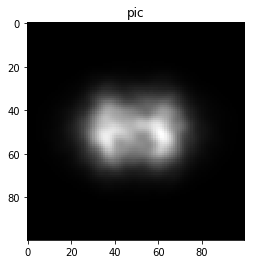

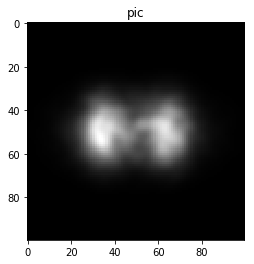

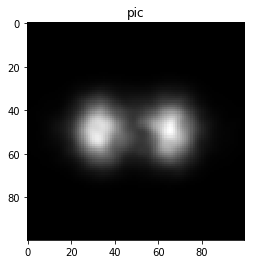

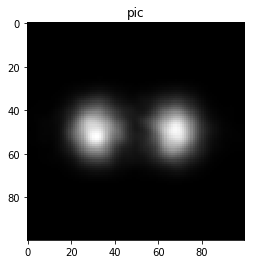

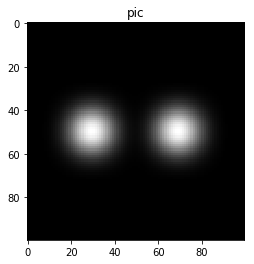

In [13]:
##test interpolate_2
x_c = cutoff(x)
y_c = cutoff(y)
mu_n, x_K, y_0 = interpolate_2(x_c,y_c,300)

for k in range(len(mu_n)):
    if k%50 == 0:
        pixels_mu = np.array([rho_T(x[i,:2],mu_n[k][:,:2],mu_n[k][:,2],delta=1e3) for i in range(100**2)])
        imgT = np.reshape(pixels_mu,(100,100))
        plt.figure(k)
        plt.title('pic')
        plt.imshow(imgT,cmap=plt.cm.gray)
        plt.show('hold')
#         plt.scatter(mu_n[k][:,0],mu_n[k][:,1], color='red',marker = 'x');
#         plt.show('hold')